# Practical Variational Inference

This is a demo of the `VariationalEnsemble` class from Bensemble which implements the Practical Variational Inference algorithm descsribed by Alex Graves in his work ["Practical Variational Inference for Neural Networks"](https://papers.nips.cc/paper_files/paper/2011/hash/7eb3c8be3d411e8ebfab08eba5f49632-Abstract.html) (2011). If interested in details, we highly advise you to check out the full paper by Graves linked above.

## Prerequisites

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import sys
from bensemble.methods.variational_inference import VariationalEnsemble

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append("../methods/")


# Set fixed seed for reproduceability
torch.manual_seed(42)
np.random.seed(42)

## Demo

Here is a demo of `VariationalEnsemble` training and testing on a synthetic regression dataset.

In [2]:
def run_test():
    # Data
    def generate_data(n_samples=150):
        torch.manual_seed(42)
        X = torch.linspace(-3, 3, n_samples).unsqueeze(1)
        y = torch.sin(X) * X + torch.randn_like(X) * 0.1
        return X, y

    X_train, y_train = generate_data()
    loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

    # Model
    base_model = nn.Sequential(
        nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1)
    )

    print("Initializing...")
    ensemble = VariationalEnsemble(
        model=base_model, prior_sigma=1.0, learning_rate=0.01, auto_convert=True
    )

    print("Training...")
    # history = ensemble.fit(loader, epochs=800, kl_weight=0.05, verbose=True)
    ensemble.fit(loader, epochs=800, kl_weight=0.05, verbose=True)

    # Testing
    X_test = torch.linspace(-6, 6, 300).unsqueeze(1)
    mean, std = ensemble.predict(X_test, n_samples=100)
    sampled_models = ensemble.sample_models(n_models=5)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train, y_train, c="black", s=10, label="Train Data", zorder=5)

    # Uncertainty
    upper = (mean + 2 * std).flatten()
    lower = (mean - 2 * std).flatten()
    plt.fill_between(
        X_test.flatten(),
        lower,
        upper,
        color="blue",
        alpha=0.2,
        label="Uncertainty (95%)",
    )
    plt.plot(X_test, mean, c="blue", linewidth=2, label="Mean Prediction")

    # Samples
    for i, model in enumerate(sampled_models):
        with torch.no_grad():
            y_sample = model(X_test)
        plt.plot(
            X_test,
            y_sample,
            c="red",
            alpha=0.3,
            linewidth=1,
            label="Sampled Model" if i == 0 else None,
        )

    plt.title("Bayesian Neural Network Test")
    plt.legend()
    plt.ylim(-4, 4)
    plt.grid(True, alpha=0.3)
    plt.show()

Initializing...
Training...
Epoch 100/800 | Loss: 148.2689 | Sigma: 0.1926
Epoch 200/800 | Loss: 32.8037 | Sigma: 0.1897
Epoch 300/800 | Loss: -7.7398 | Sigma: 0.1682
Epoch 400/800 | Loss: -27.9717 | Sigma: 0.1414
Epoch 500/800 | Loss: -35.9483 | Sigma: 0.1230
Epoch 600/800 | Loss: -40.1760 | Sigma: 0.1114
Epoch 700/800 | Loss: -45.2567 | Sigma: 0.1058
Epoch 800/800 | Loss: -47.0406 | Sigma: 0.1037


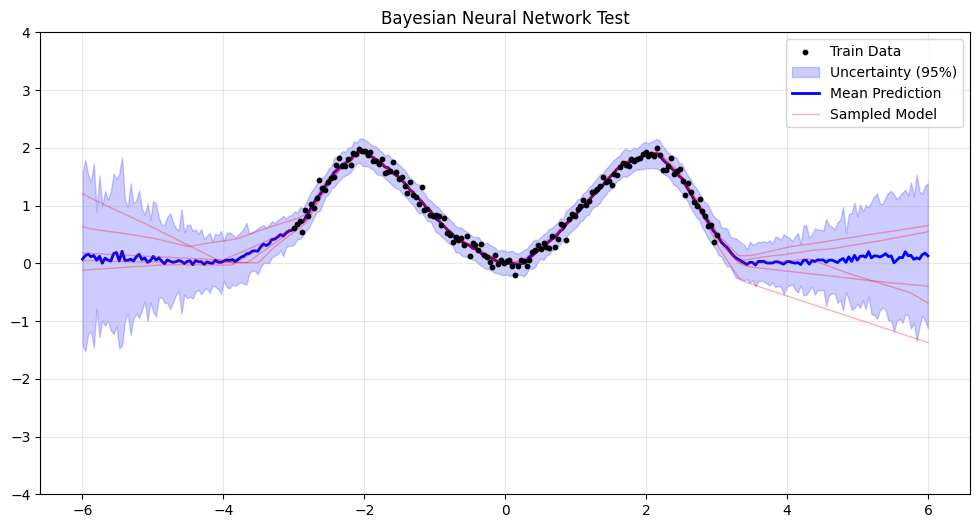

In [3]:
run_test()